In [86]:
#Chargement des bibliothÃ¨ques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pylab as pylab

os.chdir('/home/allan/Documents/PONANT/Data')


In [87]:
#Chargement de l'extrait de donnÃ©es, 
df = pd.read_excel('Data_Third_Extract.xlsx')

In [88]:

#**************************
#Data Selection
#************************
#Format datetime variables
df['FCST_DATE_CREATION'] = pd.to_datetime(df['FCST_DATE_CREATION'])
df['Date_Premiere_Reservation_Indiv'] = pd.to_datetime(df['Date_Premiere_Reservation_Indiv'])
df['PB_Changed_Date'] = pd.to_datetime(df['PB_Changed_Date'])
df['Booking_Date_OBS'] = pd.to_datetime(df['Booking_Date_OBS'])
df['Mapping_Date_Departure'] = pd.to_datetime(df['Mapping_Date_Departure'])

#SÃ©lection des donnÃ©es aprÃ¨s le 01/11/2016
df = df[df['Booking_Date_OBS'] >= '2016-11-26'] 
print(df.shape)
#Suppression des enregistrement de croisières après leurs départs
df = df[df['Booking_Date_OBS'] <= df['Mapping_Date_Departure'] ] 

#Remove lines with otal_NTR_EUR NULL
df = df[~df['Total_NTR_EUR'].isna()]
print(df.shape)
#Remove lines with Current_PB NULL
df = df[~df['Current_PB'].isna()]
print(df.shape)
#Remove lines with Current_PB NULL
df = df[~df['Key_Cruise_Code'].isna()]
print(df.shape)
#Remove lines with Current_PB NULL
df = df[~df['FCST_TOTAL_CABIN'].isna()]
print(df.shape)

#Remove group cruises
df = df[~((df['Mapping_Vessel'] == 'PONANT')  & 
   (df['Total_Cabin_Total_Group'] / df['Mapping_Cabin_Capacity'] >= 0.7)) ]
df = df[~((df['Mapping_Vessel'] != 'PONANT')  & 
   (df['Total_Cabin_Total_Group'] / df['Mapping_Cabin_Capacity'] >= 0.90)) ]
df = df[~df['Date_Premiere_Reservation_Indiv'].isna()]
print(df.shape)

(53072, 116)
(44163, 116)
(43079, 116)
(43079, 116)
(42145, 116)
(41017, 116)


In [89]:

#Tri des donnÃ©es par Code croisiÃ¨re et date
df = df.sort_values(['Key_Cruise_Code' , 'Booking_Date_OBS'])
df.nunique(dropna = False)[df.nunique(dropna = False) == 1]


Mapping_Charter                   1
Mapping_Cruise_Status             1
Mapping_Destination_Production    1
Mapping_Cluster_ML                1
Mapping_Histo_ML                  1
dtype: int64

In [90]:
#********************************
#Select variables
#********************************
#suppression des variables statiques
variables_to_remove = ['Mapping_Charter',
                       'Mapping_Cruise_Status',
                       'Mapping_Cluster_ML',
                       'Mapping_Histo_ML',
                       'Mapping_Destination_Production',
                       'FCST_UID',
                       'FCST_DATE',
                       'ID',
                       'Delay_PB_Changed_Days_MIN',
                       'FCST_COMMENTAIRES',
                       'CRUISE_CODE'
                       ]
df.drop(variables_to_remove , axis = 1, inplace = True)


In [91]:
#**************************
#Variables format
#************************
#Check string variables
print(df.dtypes[df.dtypes == "object"].index)
df[list(df.dtypes[df.dtypes == "object"].index)].head()


Index(['Mapping_Vessel', 'Mapping_From_To', 'Mapping_Destination',
       'Mapping_Season', 'Mapping_Theme', 'Mapping_Guest',
       'Mapping_Partnership', 'Mapping_Cluster_Pricing', 'Mapping_FCST_Model',
       'Mapping_Destination_Semester', 'Mapping_Cluster_Pricing_2',
       'Key_Cruise_Code', 'FCST_STATUS', 'FCST_Editor'],
      dtype='object')


Mapping_Vessel            Mapping_From_To Mapping_Destination  \
70        AUSTRAL  Port Vila - Kota Kinabalu             Oceania   
71        AUSTRAL  Port Vila - Kota Kinabalu             Oceania   
72        AUSTRAL  Port Vila - Kota Kinabalu             Oceania   
73        AUSTRAL  Port Vila - Kota Kinabalu             Oceania   
74        AUSTRAL  Port Vila - Kota Kinabalu             Oceania   

      Mapping_Season Mapping_Theme Mapping_Guest Mapping_Partnership  \
70  WINTER 2016-2017           NaN           NaN                 NaN   
71  WINTER 2016-2017           NaN           NaN                 NaN   
72  WINTER 2016-2017           NaN           NaN                 NaN   
73  WINTER 2016-2017           NaN           NaN                 NaN   
74  WINTER 2016-2017           NaN           NaN                 NaN   

   Mapping_Cluster_Pricing Mapping_FCST_Model Mapping_Destination_Semester  \
70               Melanesia               HIGH                   Oceania S1   
71               Melanesia               HIGH                   Oceania S1   
72               Melanesia               HIGH                   Oceania S1   
73               Melanesia               HIGH                   Oceania S1   
74               Melanesia               HIGH                   Oceania S1   

                            Mapping_Cluster_Pricing_2 Key_Cruise_Code  \
70  Indonesia & New Guinea & Solomon Islands & Van...         A010317   
71  Indonesia & New Guinea & Solomon Islands & Van...         A010317   
72  Indonesia & New Guinea & Solomon Islands & Van...         A010317   
73  Indonesia & New Guinea & Solomon Islands & Van...         A010317   
74  Indonesia & New Guinea & Solomon Islands & Van...         A010317   

   FCST_STATUS       FCST_Editor  
70  FullAnayst  PONANT\yesposito  
71  FullAnayst  PONANT\yesposito  
72  FullAnayst  PONANT\yesposito  
73  FullAnayst  PONANT\yesposito  
74  FullAnayst  PONANT\yesposito

In [92]:
#Define previous_PB_value
first_lines_cruises = list(df[['Key_Cruise_Code']].reset_index().groupby('Key_Cruise_Code').first()['index'].values)
df['previous_PB_value'] =    df.loc[:,'Current_PB'].shift(1)
df.loc[first_lines_cruises , 'previous_PB_value'] =  df['Current_PB']

In [93]:
#********************************
#Correct values
#********************************
#Delay_PB_Changed_Days
df0 = df[[ 'Key_Cruise_Code',
          'Booking_Date_OBS', 
          'Current_PB',
 'Current_SupSingle',
 'Current_NeedDateLevel',
 'PB_Changed_Date',
 'Delay_PB_Changed_Days',
 'PB_CHANGED']]
df.reset_index(inplace = True, drop = True)
index_PB_Changed = list(df.loc[df['PB_CHANGED'] == 1 , 'Delay_PB_Changed_Days'].index)
index_PB_Changed = [ind for ind in index_PB_Changed if (ind not in first_lines_cruises)]
df['previous_PB_Changed_Date'] =  df.loc[:,'PB_Changed_Date'].shift(1)
df.loc[index_PB_Changed, 'Delay_PB_Changed_Days'] = (df.loc[index_PB_Changed, 'Booking_Date_OBS'] - df.loc[index_PB_Changed,'previous_PB_Changed_Date']).dt.days
#df = df.drop(['previous_PB_Changed_Date',
#              'PB_CHANGED',
#              'PB_Changed_Date'] ,  axis = 1)
                       
#Mapping season to [Winter/Summer]
df['Mapping_Season'] = df['Mapping_Season'].apply(lambda x:''.join([c for c in x if c.isalpha()]))


In [94]:

#********************************
#Missing Values
#********************************
#Categorical Variables
df = df[~df['Mapping_FCST_Model'].isna() ]
df.loc[df['Mapping_Theme'].isna() , 'Mapping_Theme'] = 'No_Theme'
df.loc[df['Mapping_Guest'].isna() , 'Mapping_Guest'] = 'No_Guest'
df.loc[df['Mapping_Partnership'].isna() , 'Mapping_Partnership'] = 'No_Partnership'
#Continious Variables
df.loc[df['Moyenne_PB'].isna(), 'Moyenne_PB'] = df.loc[df['Moyenne_PB'].isna(), 'Current_PB'] * -1 
#Remplacer les valeurs manquantes en 0 pour certaines valeurs manquantes
nan_to_zeros_var = list(df.dtypes[(df.dtypes != 'object' ) & (df.dtypes !='datetime64[ns]')].index)
df[nan_to_zeros_var] = df[nan_to_zeros_var].fillna(0)

#Nombre de Valeurs manquantes par colonnes
df.isnull().sum()

Mapping_Vessel                   0
Mapping_LOS                      0
Mapping_Date_Departure           0
Mapping_Year_Departure           0
Mapping_From_To                  0
Mapping_Destination              0
Mapping_Season                   0
Mapping_Theme                    0
Mapping_Guest                    0
Mapping_Partnership              0
Mapping_Cluster_Pricing          0
Mapping_FCST_Model               0
Mapping_Destination_Semester     0
Mapping_Cluster_Pricing_2        0
Mapping_Cabin_Capacity           0
Mapping_Lead_Time_Days           0
Key_Cruise_Code                  0
Total_Pax_Paying                 0
Total_Cab_Paying                 0
Total_NTR_EUR                    0
Total_PCD_Paying                 0
Total_CCD_Paying                 0
Moyenne_PerDiem_Cabine_EUR       0
Moyenne_PerDiem_Pax_EUR          0
Total_Dispo_Cabine               0
Occupation_Rate_excl_OPT         0
Nombre_Singles                   0
Moyenne_PB                       0
Total_Cab_PB_30     

In [95]:
#Lecture de la table PBSSCALENDAR
df_PB = pd.read_excel('PBSSCALENDAR.xlsx')
#Les variables clairement inutiles Ã  la problÃ¨matique sont Ã  supprimer
df_PB.drop([ 'ID', 
             'UID', 
             'Editor', 
             'Creation_Timestamp', 
             'Edition_Timestamp',
             'SS_CAL_Amount',
             'PBSS_LT_Week',
             'ND_CAL_Amount',] , axis = 1 ,inplace = True)
df_PB['PBSS_CAL_Date'] = pd.to_datetime(df_PB['PBSS_CAL_Date'])
df_PB['PBSS_CAL_Date']  = df_PB['PBSS_CAL_Date'] + pd.DateOffset(1)
df_PB.columns = ['Cruise_Code', 'PBSS_CAL_Date', 'PB_the_day_before']
df = pd.merge(left = df,
              right = df_PB,
              left_on = ['Key_Cruise_Code' , 'Booking_Date_OBS' ],
              right_on = ['Cruise_Code' , 'PBSS_CAL_Date'] ,
              how = 'left')
df = df[~df['Cruise_Code'].isna()]
df = df.drop( ['Cruise_Code' ,   'PBSS_CAL_Date' ] ,axis  =1)



In [101]:

#Statistiques desvariables continues
categorical_variables = list(df.dtypes[df.dtypes == 'object'].index)
datetime_variables = list(df.dtypes[df.dtypes == 'datetime64[ns]'].index)
continious_variables = [col for col in list(df.columns) 
                        if(col not in(categorical_variables + datetime_variables)) ]
df.describe().to_csv('stats.csv', sep = ';')


Mapping_LOS  Mapping_Year_Departure  Mapping_Cabin_Capacity  \
count  40948.000000            40948.000000            40948.000000   
mean       9.872643             2018.625183              109.303482   
std        3.272474                0.848405               29.294392   
min        1.000000             2016.000000               31.000000   
25%        7.000000             2018.000000               92.000000   
50%        9.000000             2019.000000              122.000000   
75%       12.000000             2019.000000              132.000000   
max       22.000000             2020.000000              132.000000   

       Mapping_Lead_Time_Days  Total_Pax_Paying  Total_Cab_Paying  \
count            40948.000000      40948.000000      40948.000000   
mean               353.130287        108.256691         66.588722   
std                192.495532         74.262702         42.557613   
min                  0.000000        -32.000000          0.000000   
25%                194.000000         34.000000         25.000000   
50%                363.000000        114.000000         71.000000   
75%                510.000000        170.000000        103.000000   
max                793.000000        256.000000        139.000000   

       Total_NTR_EUR  Total_PCD_Paying  Total_CCD_Paying  \
count   4.094800e+04      40948.000000      40948.000000   
mean    5.900864e+05       1106.739294        671.954894   
std     5.707361e+05        897.378667        510.772799   
min    -5.064596e+05        -32.000000          0.000000   
25%     1.344830e+05        304.000000        216.000000   
50%     4.907594e+05       1044.000000        630.000000   
75%     8.577050e+05       1610.000000        950.000000   
max     4.056803e+06       5478.000000       5130.000000   

       Moyenne_PerDiem_Cabine_EUR        ...          FCST_EROSION_OFFRES  \
count                40948.000000        ...                 40948.000000   
mean                   687.994584        ...                     0.081532   
std                   1689.766353        ...                     0.101205   
min                 -48855.992350        ...                     0.000000   
25%                    574.542837        ...                     0.043000   
50%                    772.517111        ...                     0.060000   
75%                    981.416680        ...                     0.083000   
max                  30318.780000        ...                     1.000000   

       FCST_EROSION_COMMISSION  FCST_EROSION_SINGLE  FCST_TOTAL_REVENUE  \
count             40948.000000         40948.000000        4.094800e+04   
mean                  0.078942             0.075675        9.611646e+05   
std                   0.028058             0.079619        6.485081e+05   
min                   0.000000             0.000000        0.000000e+00   
25%                   0.069000             0.012000        5.513568e+05   
50%                   0.079000             0.073000        8.473090e+05   
75%                   0.090000             0.100000        1.313092e+06   
max                   1.000000             1.000000        4.503635e+06   

       FCST_TOTAL_CABIN  Pick_Up_Group_1w  Pick_Up_Group_2w  \
count      40948.000000      40948.000000      40948.000000   
mean         106.211244          0.056389          0.126355   
std           31.322033          1.529421          2.320832   
min            1.000000        -90.000000        -90.000000   
25%           91.000000          0.000000          0.000000   
50%          119.000000          0.000000          0.000000   
75%          130.000000          0.000000          0.000000   
max          132.000000         69.000000         73.000000   

       Duree_Commercialisation_Month  previous_PB_value  PB_the_day_before  
count                   40948.000000       40948.000000       40948.000000  
mean                       21.166455           0.155693           0.154526  
std                         2.871544

In [102]:
#EXtract Negative values
V = pd.DataFrame(df[continious_variables].min()[df[continious_variables].min()<0])
V['Key_Cruise_Code'] = 'A'
V.columns = ['min' , 'Key_Cruise_Code']
for ind in list(V.index):
    V.loc[ ind , 'Key_Cruise_Code'] = df.loc[df[ind] == V.loc[ind , 'min'], 'Key_Cruise_Code'].iloc[0]
V.to_csv('valid.csv', sep = ';')


In [107]:

#Correlation
df[continious_variables].corr().sort_values('PB_the_day_before').to_csv('correlation_matrix.csv')
df[continious_variables].corr().sort_values('PB_the_day_before').loc[:,'Current_PB']


Moyenne_PB                           -0.801808
Occupation_Rate_Ponts_Sup_excl_OPT   -0.802201
Occupation_Rate_excl_OPT             -0.802315
Yield                                -0.760517
Current_SupSingle                    -0.757428
Occupation_Rate_Ponts_Inf_excl_OPT   -0.745352
Total_Cabin_Paying_Sup               -0.727609
Total_Pax_Paying                     -0.703671
Total_Cab_Paying                     -0.665798
FCST_PB0                             -0.614905
Total_Pax_Paying_Indiv               -0.607294
Total_Cabin_Paying_Indiv             -0.589229
Total_Cab_PB_0                       -0.587707
Total_PCD_Paying                     -0.568755
Total_Pax_Paying_Direct              -0.549851
Total_Cabin_Paying_Inf               -0.547298
Total_NTR_EUR                        -0.542525
Total_CCD_Paying                     -0.533753
Total_Pax_Paying_FBS                 -0.495560
Total_NTR_EUR_INDIV                  -0.481725
Total_NTR_Max                        -0.474475
Total_Cab_PB_

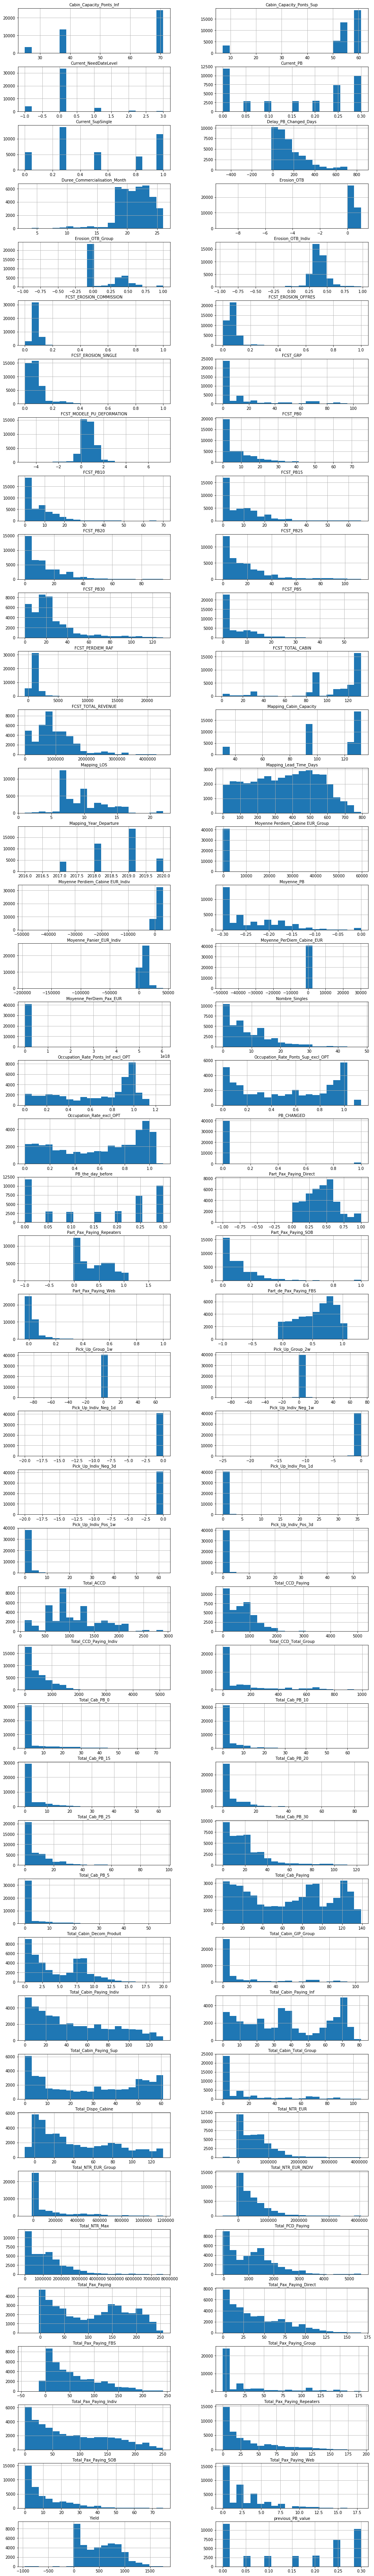

In [99]:

params = { 'axes.titlesize': 10,}
pylab.rcParams.update(params)

#Histogrammes des variables continues
df[continious_variables].dropna(axis = 0).hist(bins=20, 
                              figsize=(16,120), 
                              xlabelsize = 10,
                              ylabelsize = 10,
                              layout=(44, 2) )
plt.show()

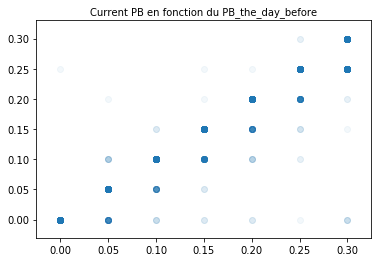

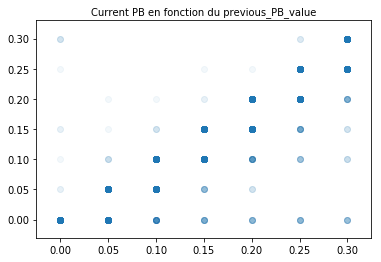

In [100]:
plt.scatter(  df['PB_the_day_before'], df[ 'Current_PB'] , alpha = 0.05)
plt.title("Current PB en fonction du PB_the_day_before")
plt.show()
plt.scatter(  df['previous_PB_value'], df[ 'Current_PB'] , alpha = 0.05)
plt.title("Current PB en fonction du previous_PB_value")

plt.show()

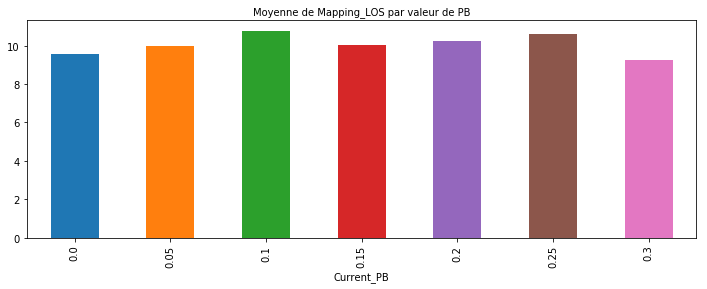

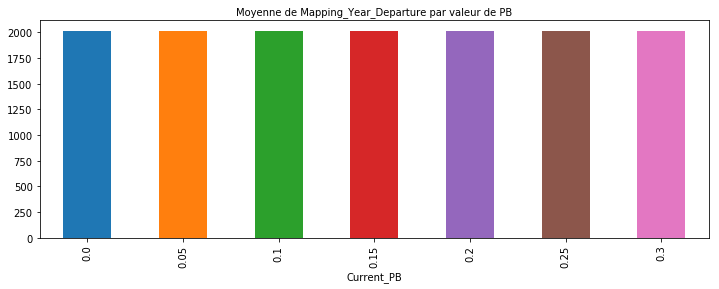

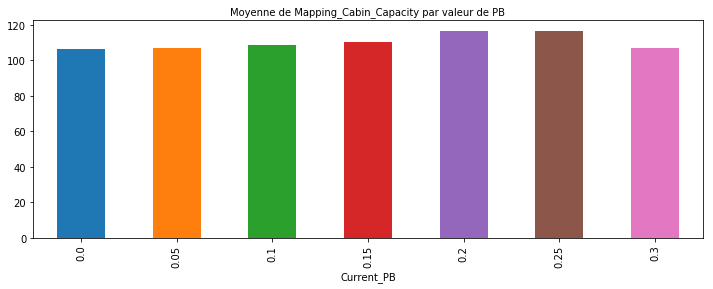

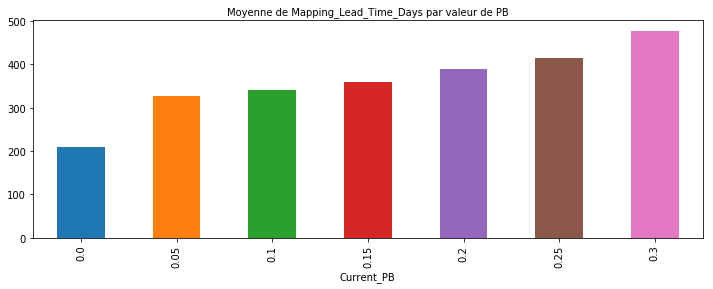

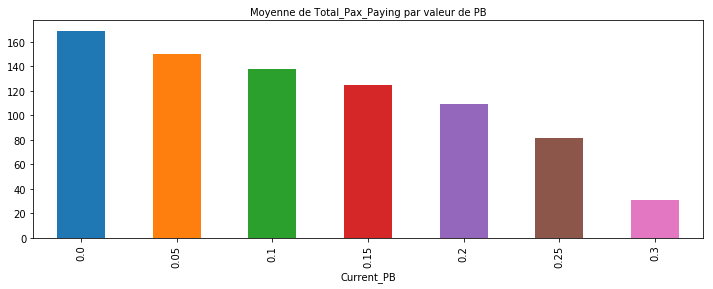

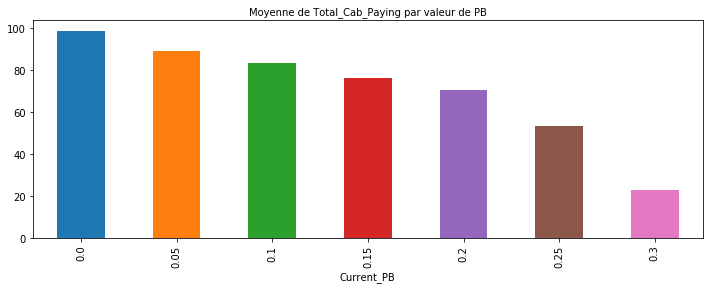

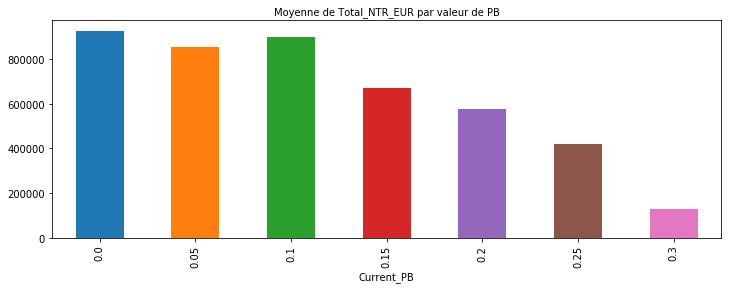

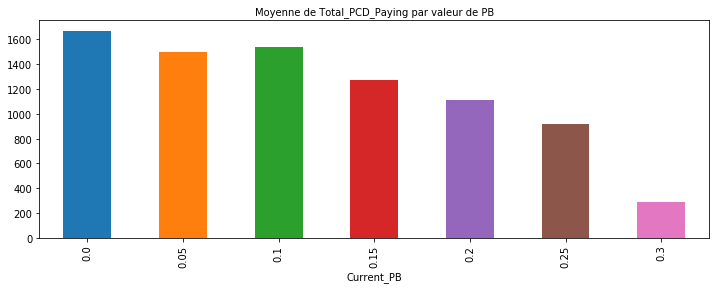

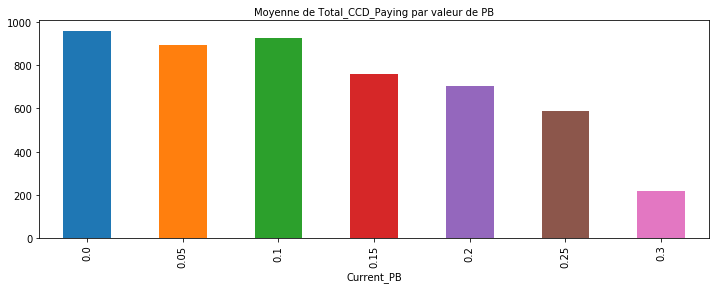

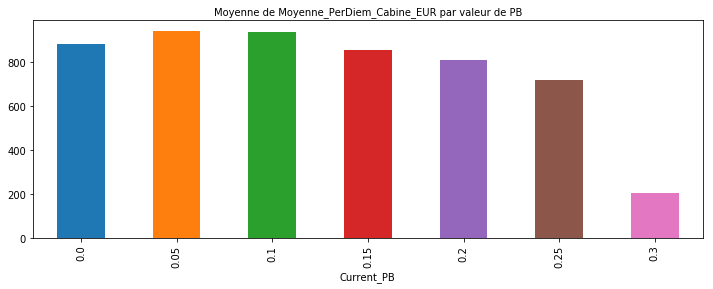

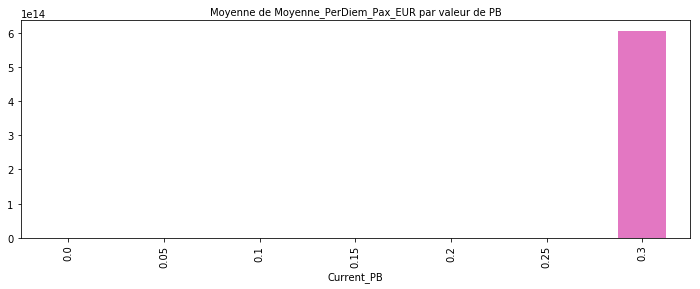

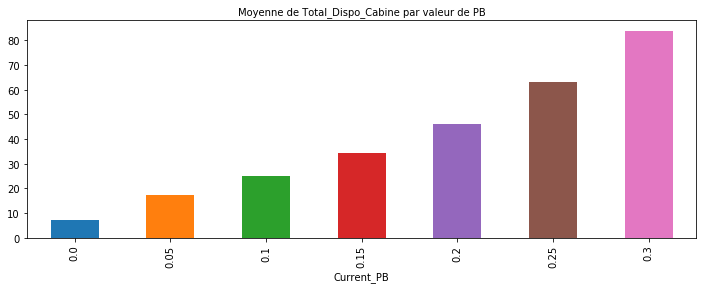

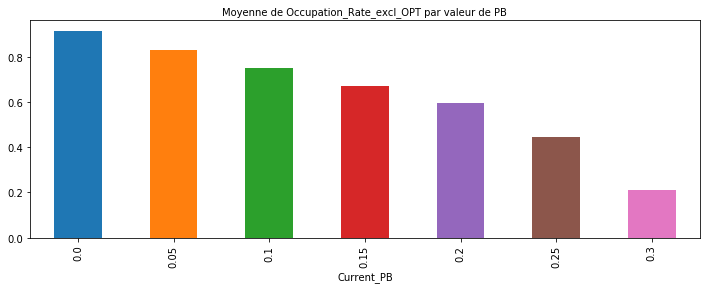

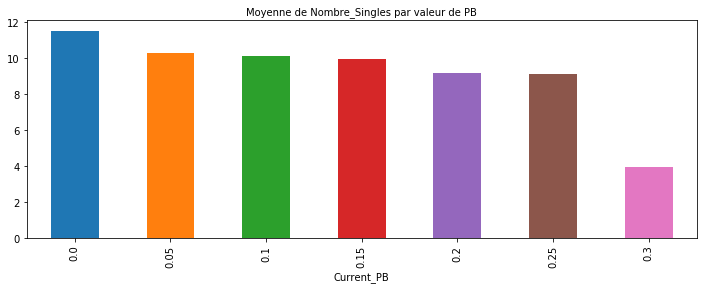

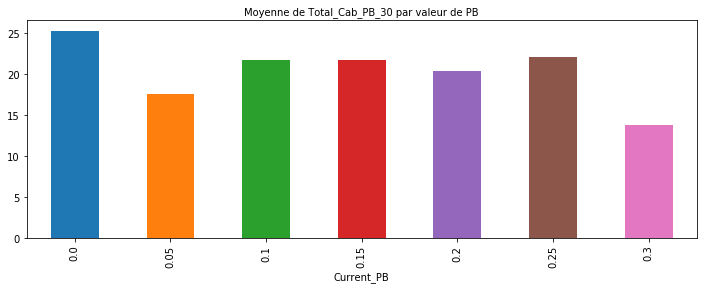

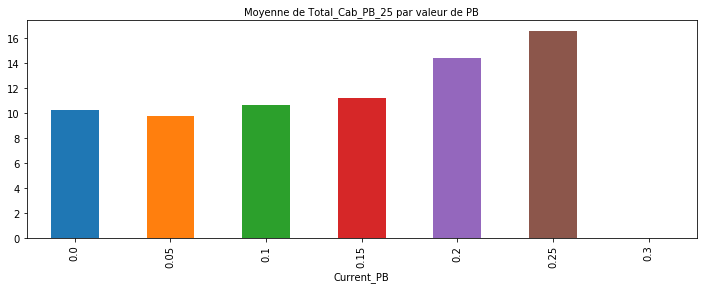

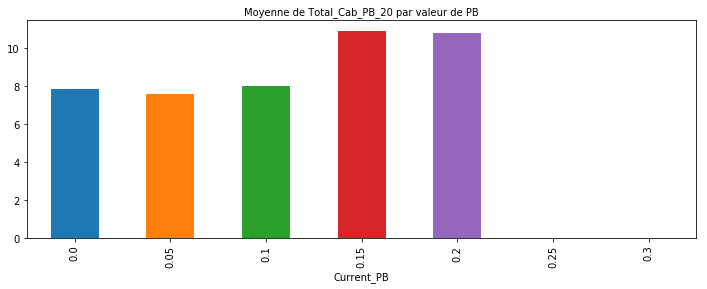

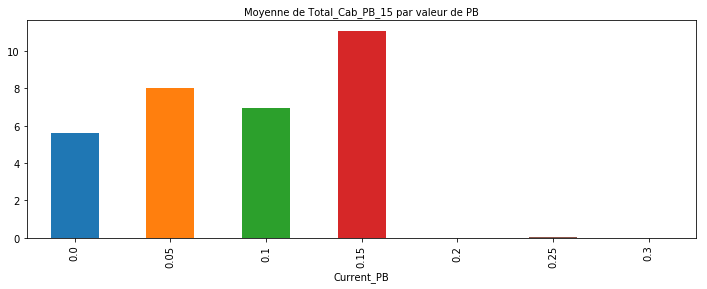

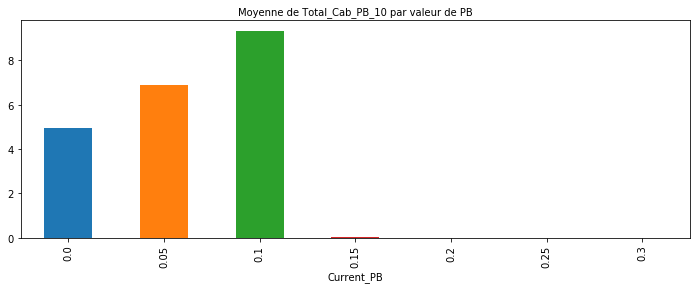

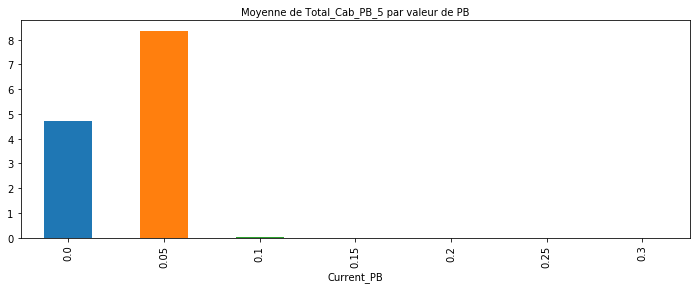

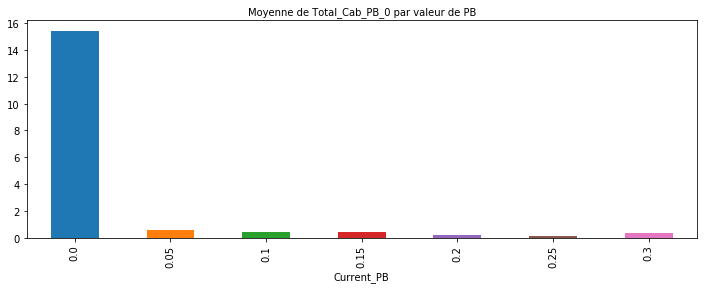

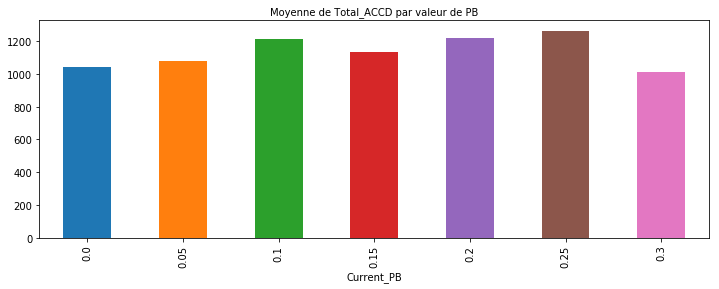

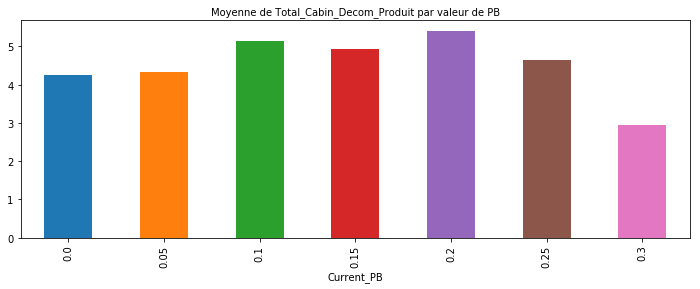

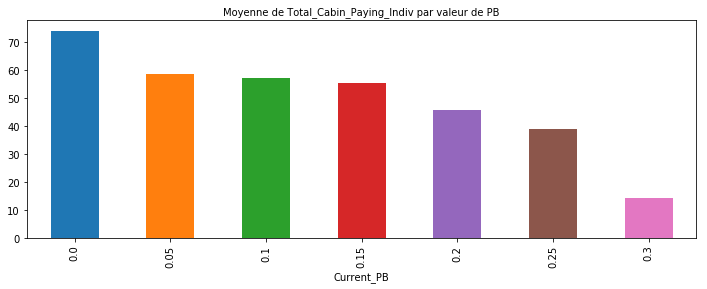

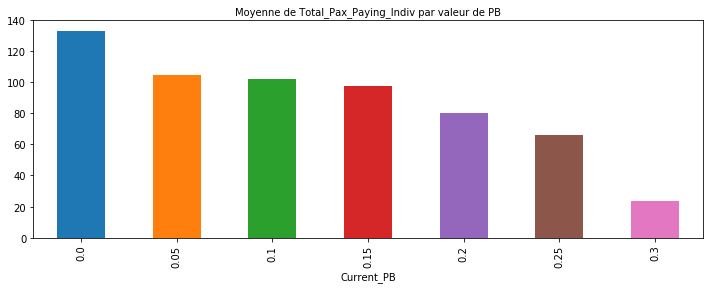

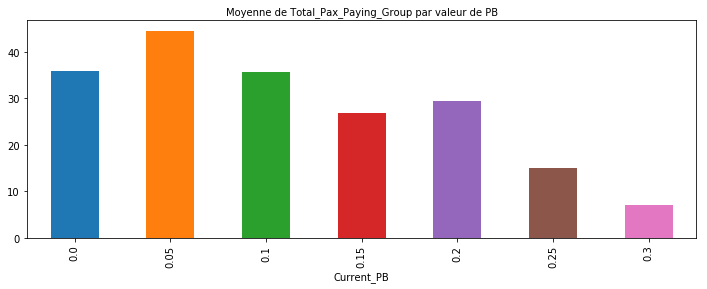

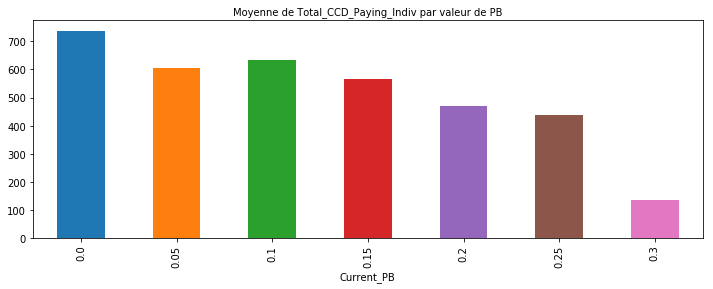

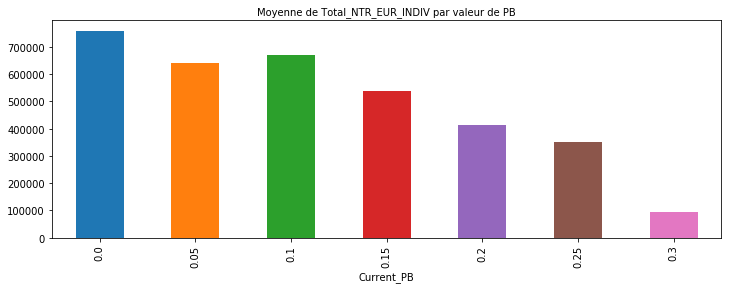

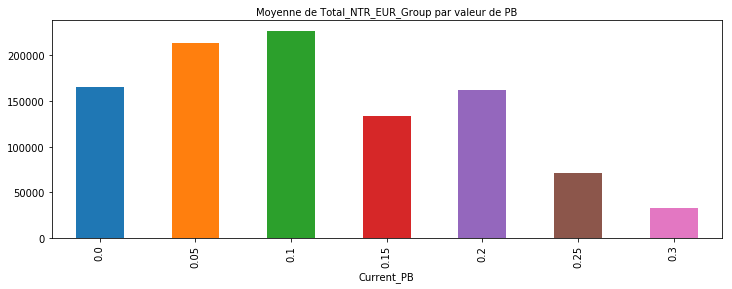

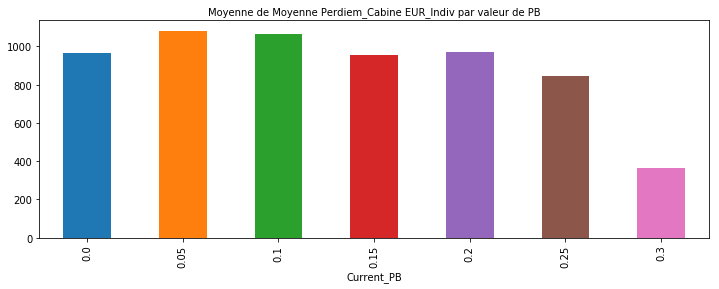

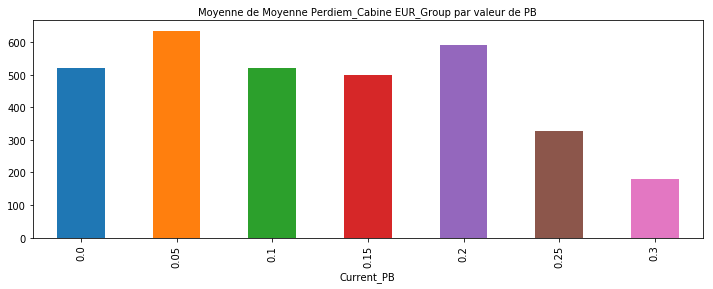

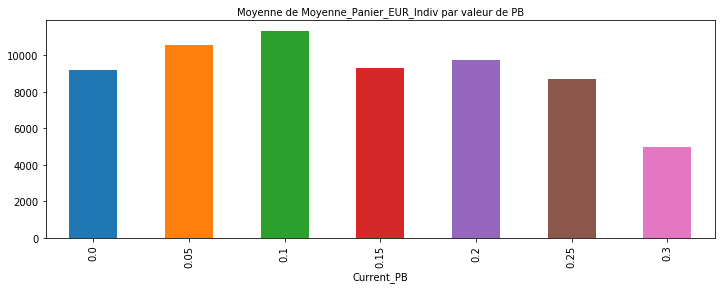

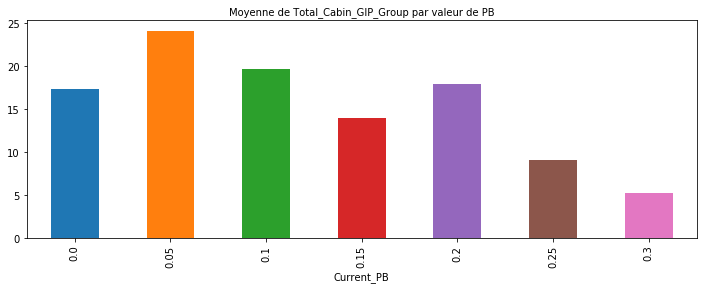

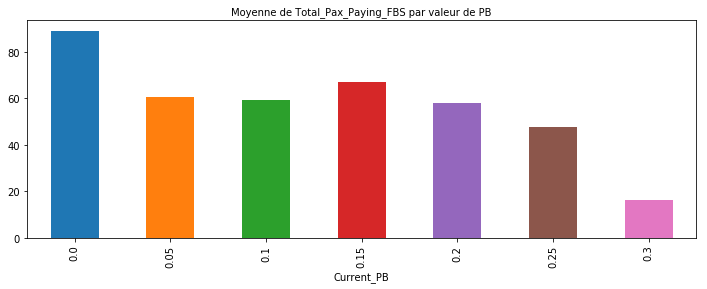

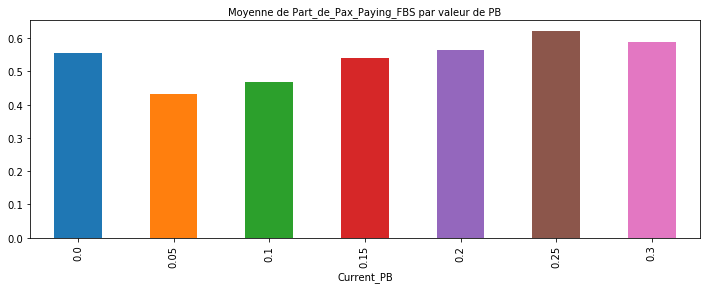

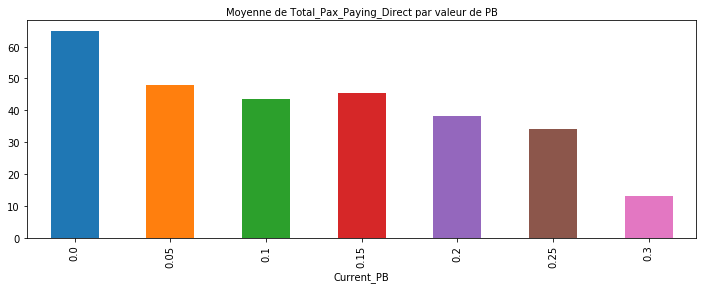

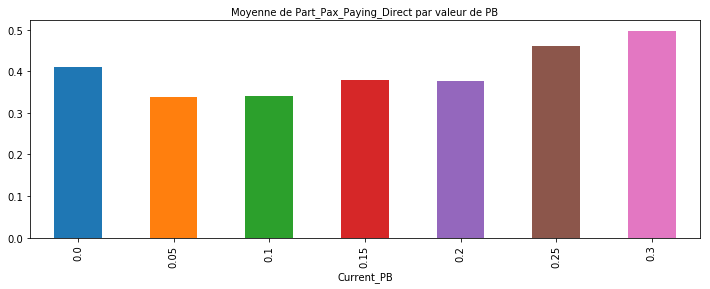

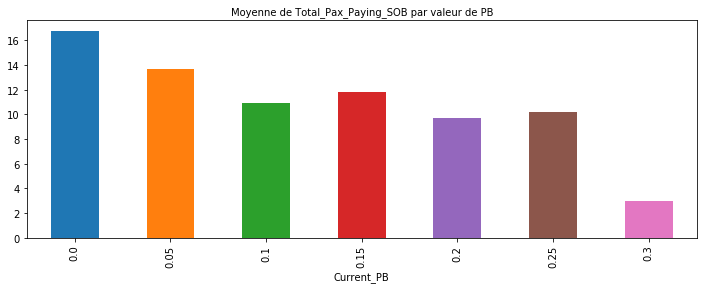

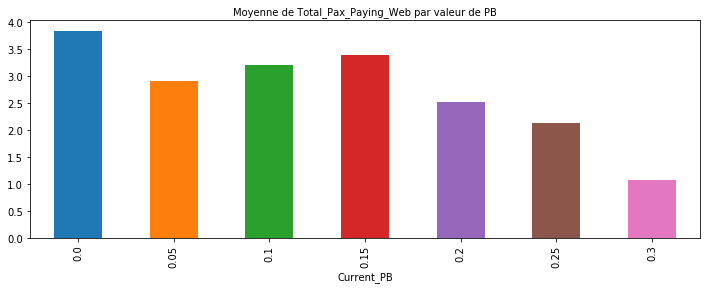

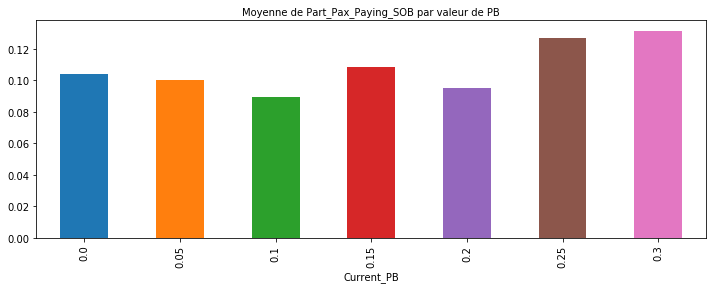

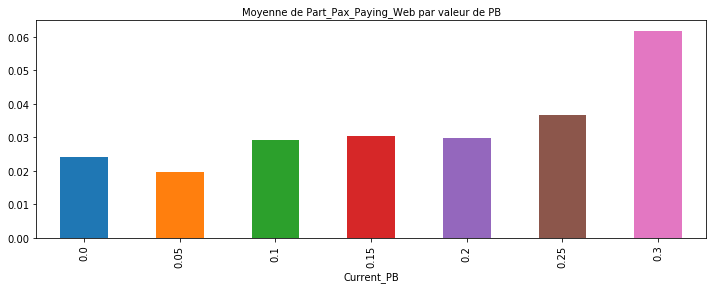

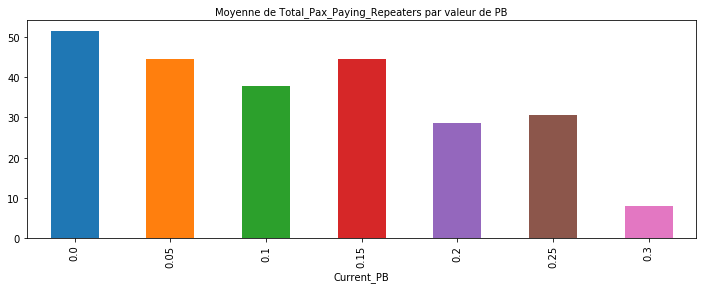

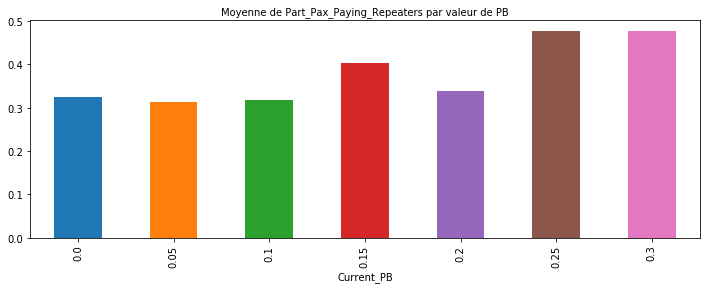

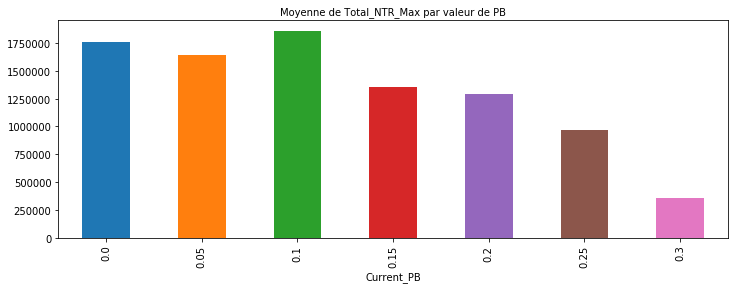

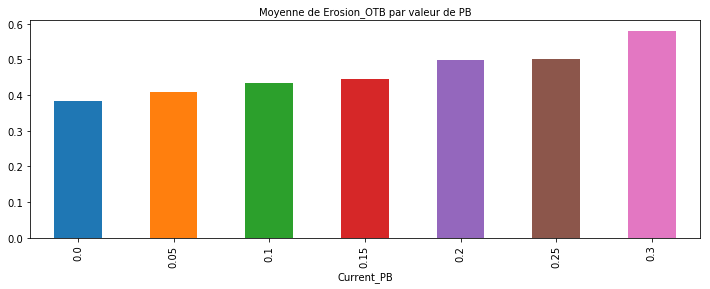

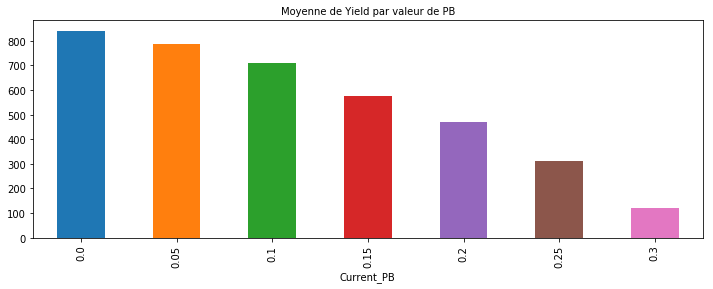

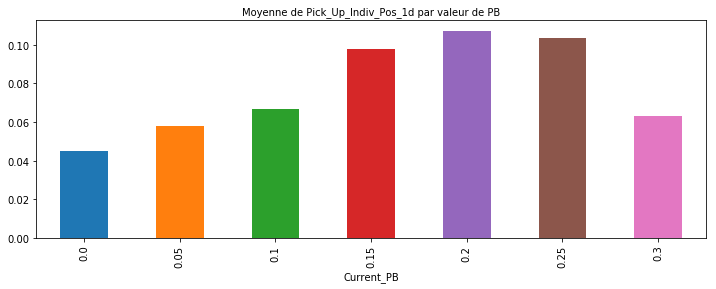

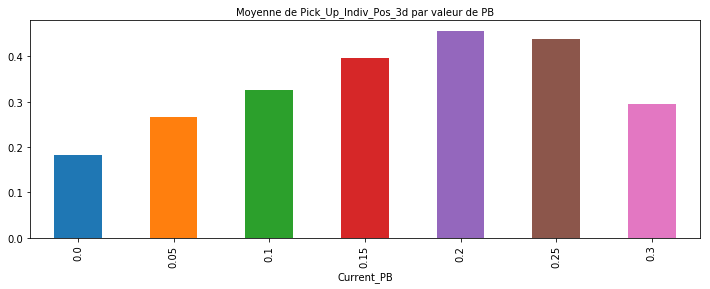

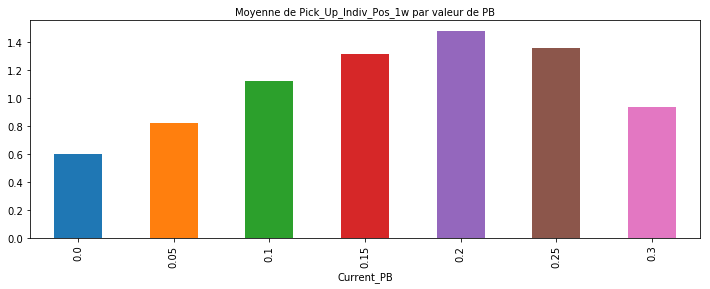

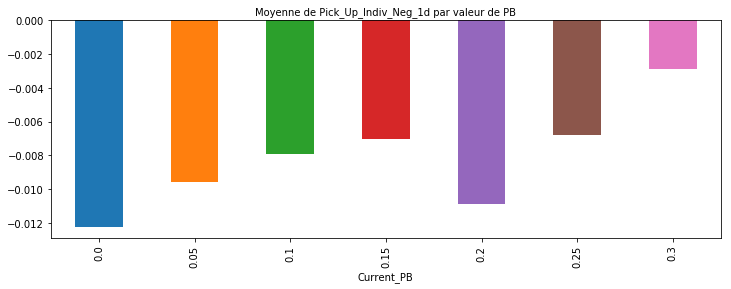

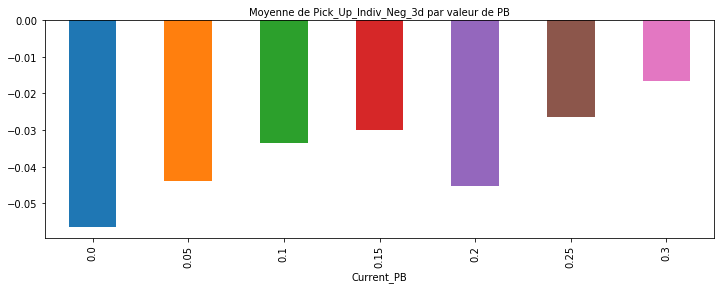

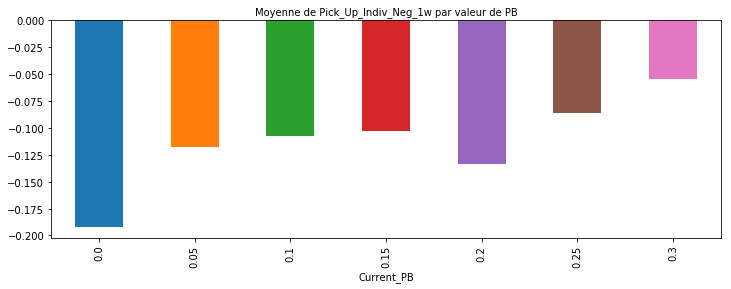

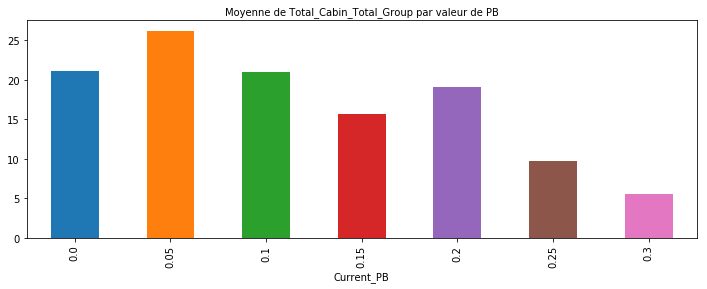

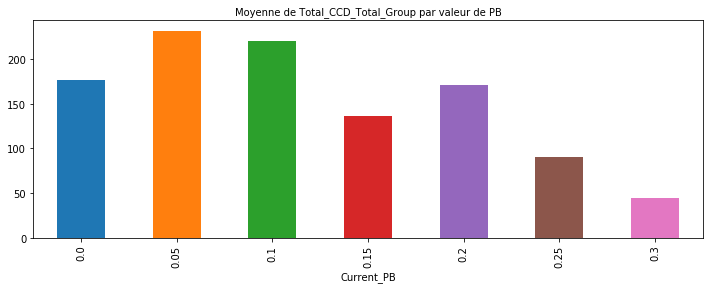

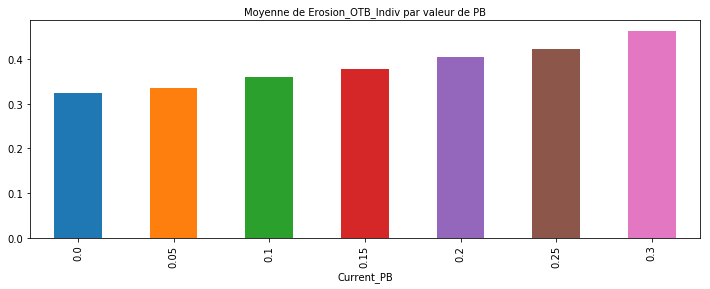

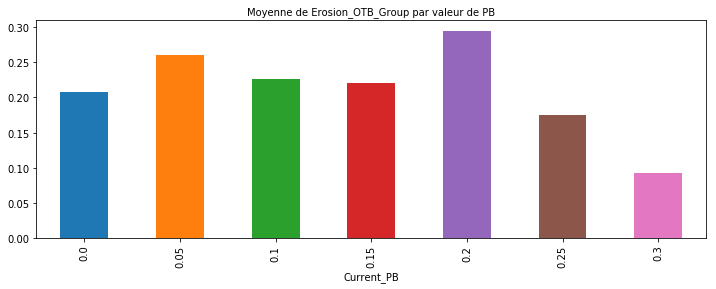

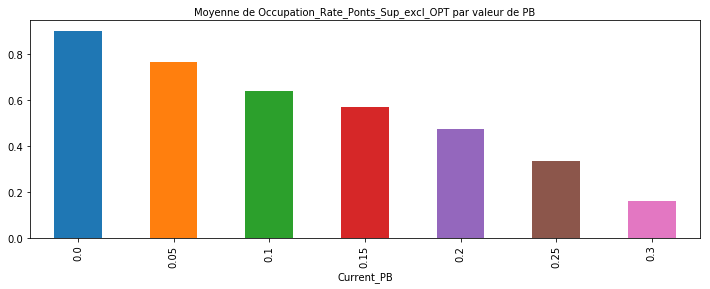

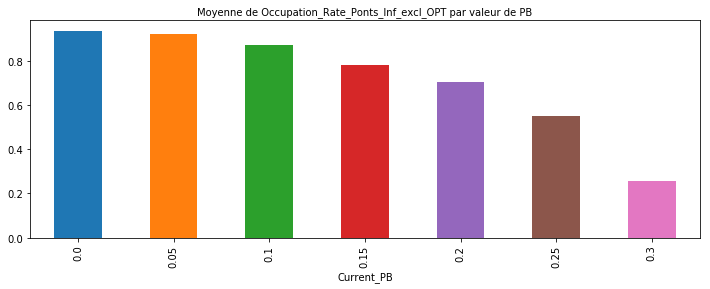

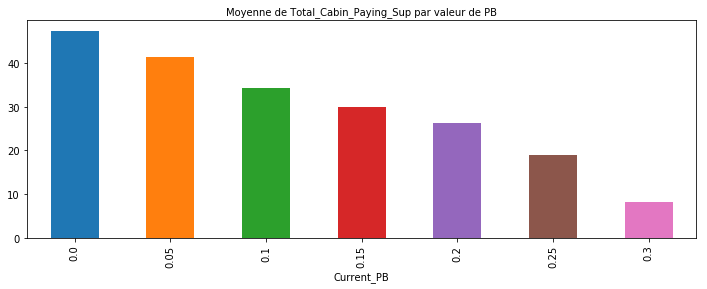

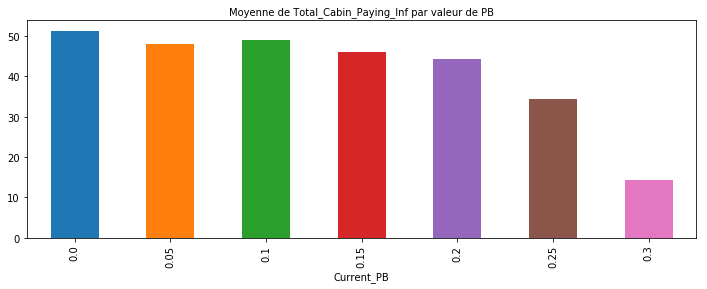

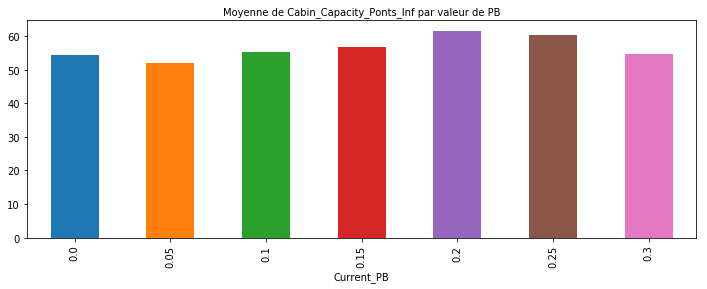

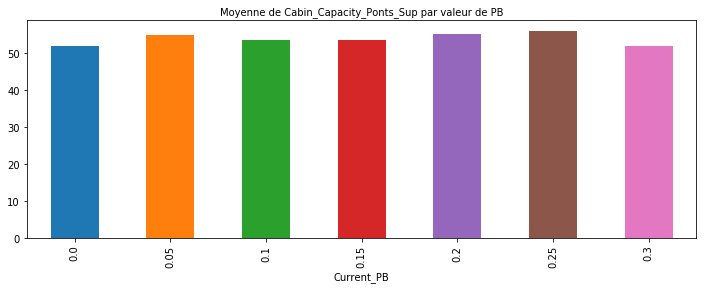

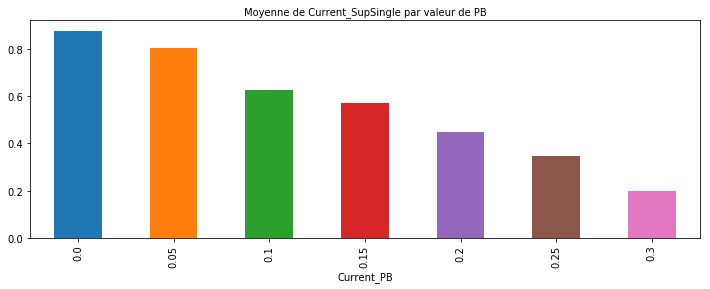

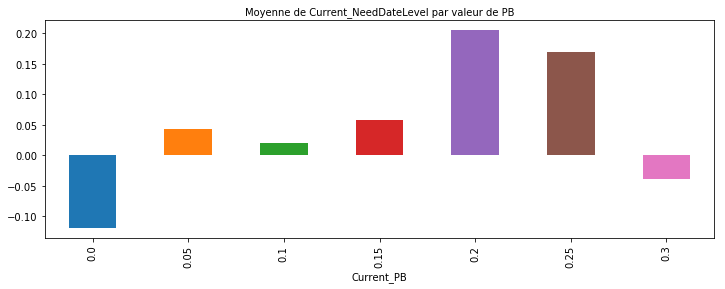

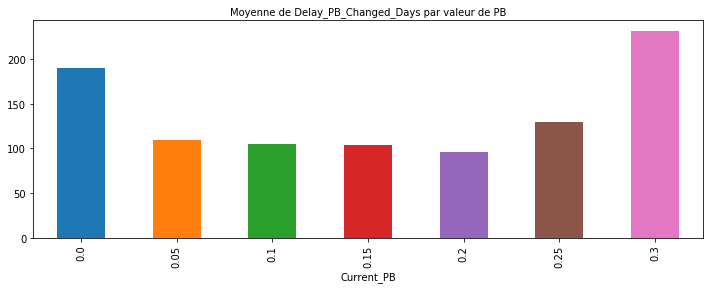

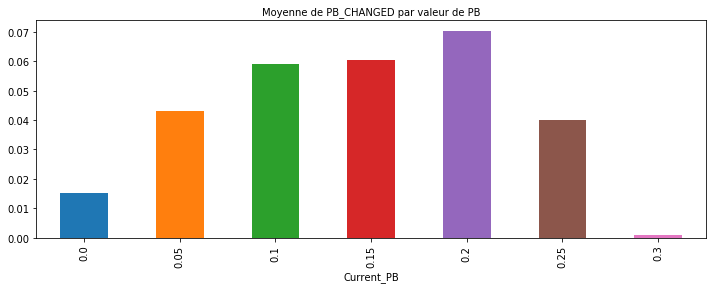

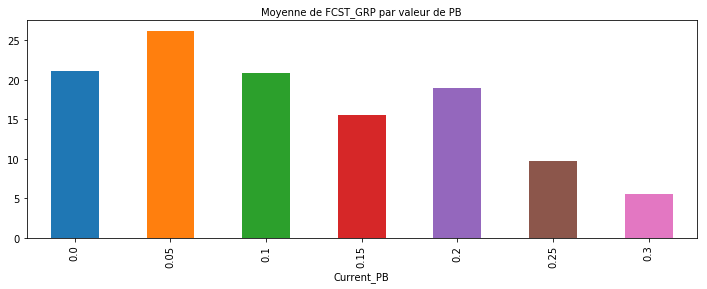

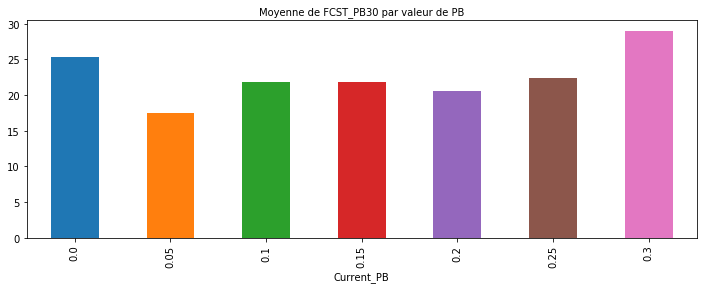

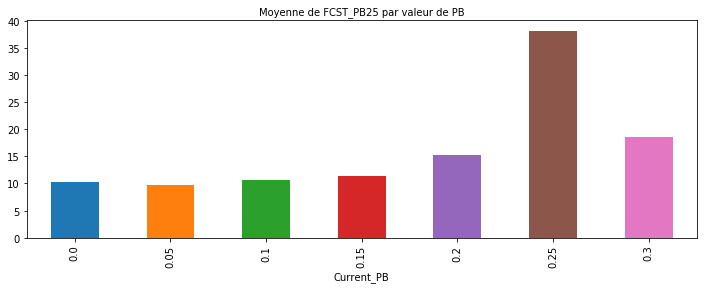

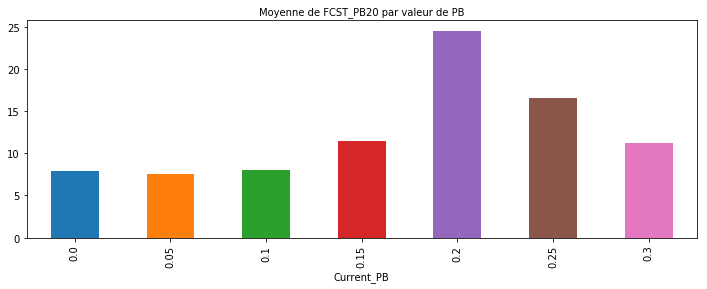

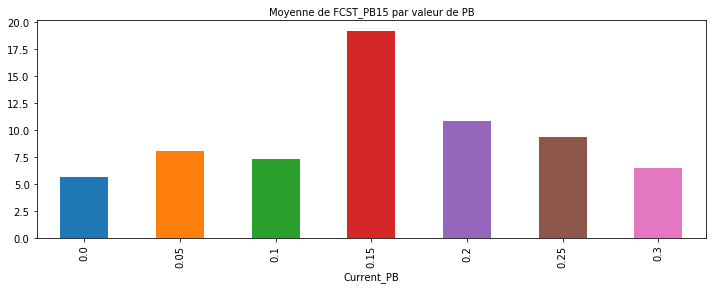

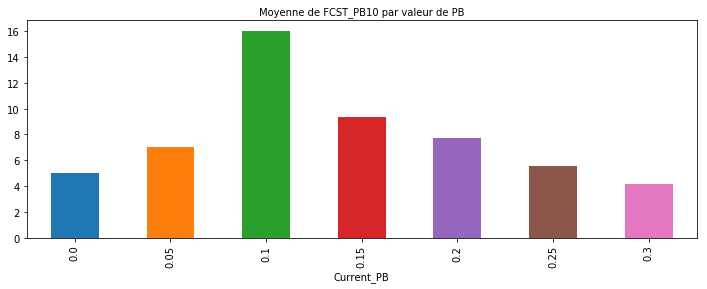

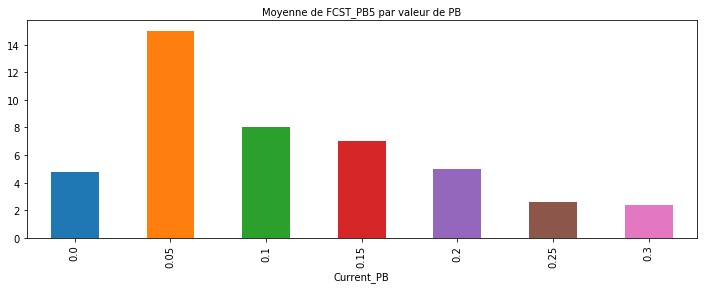

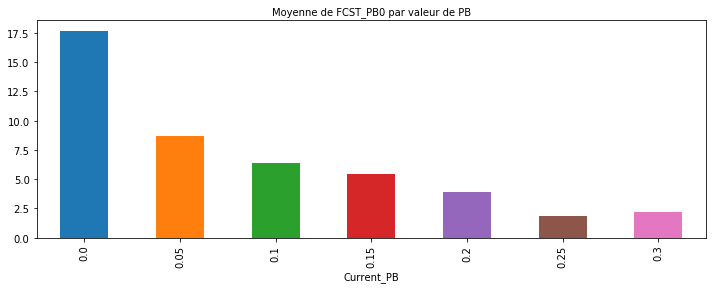

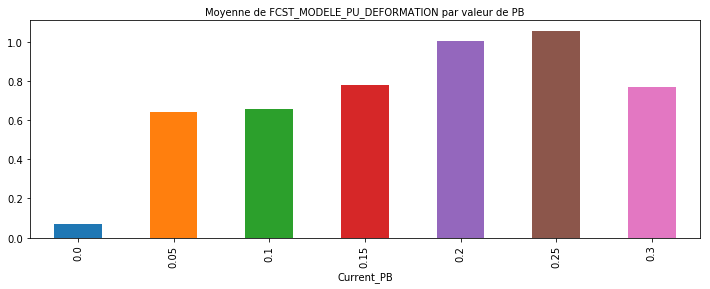

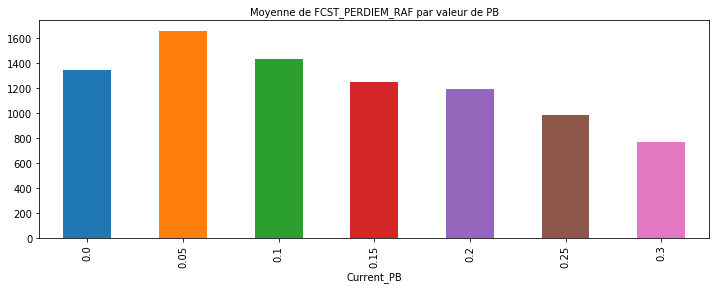

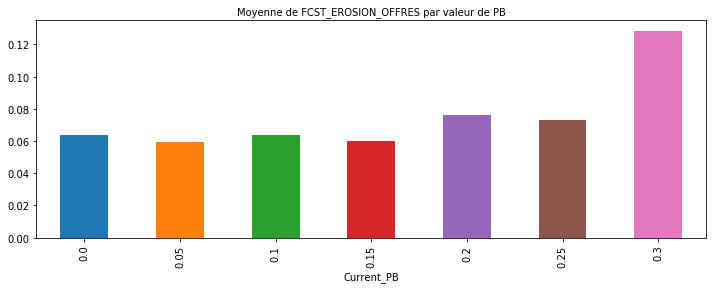

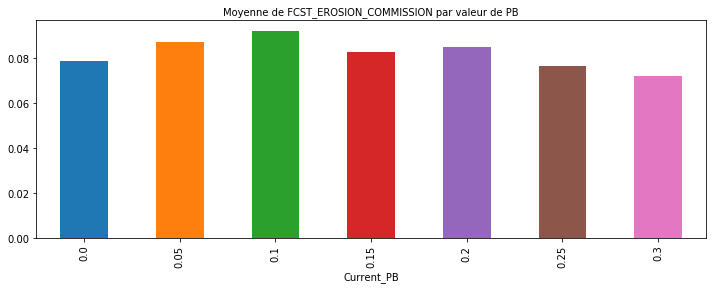

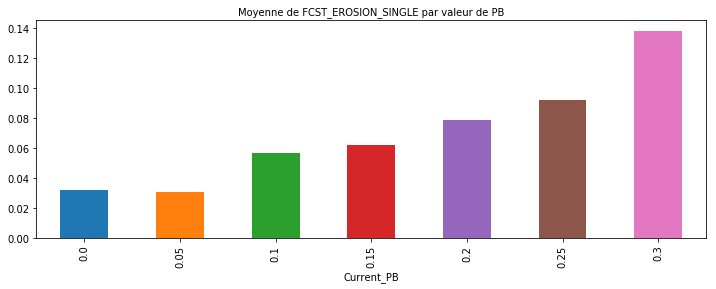

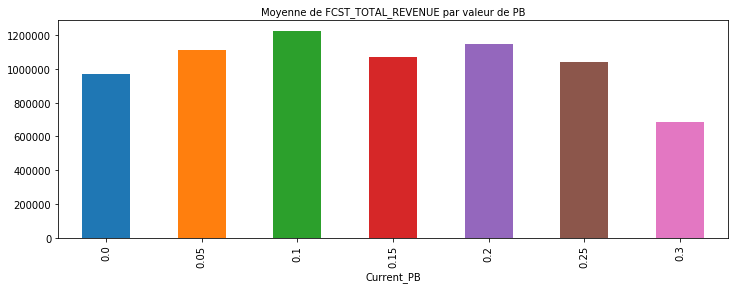

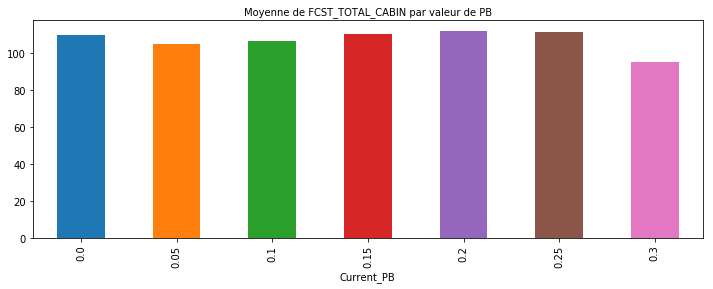

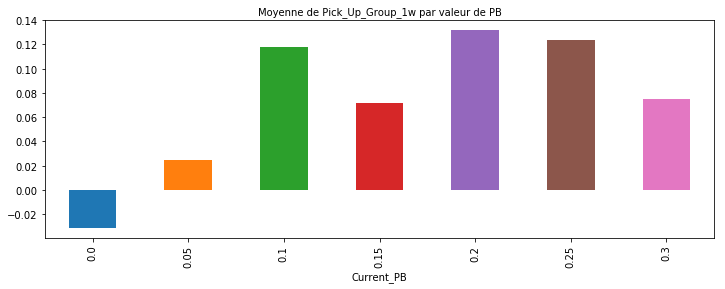

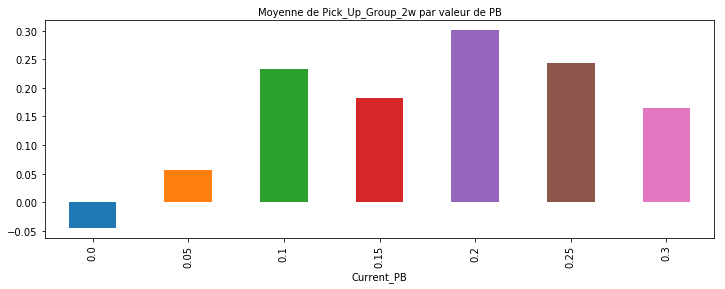

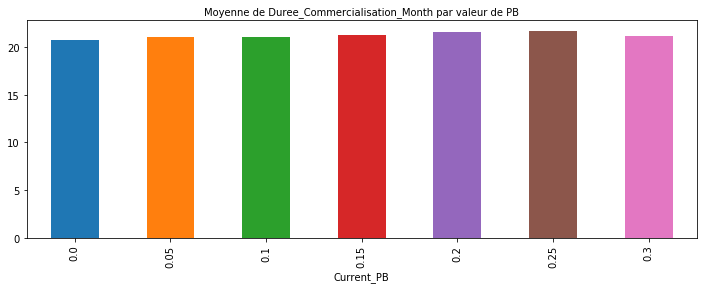

In [31]:
params = { 'axes.titlesize': 10,}
pylab.rcParams.update(params)
df_grp = df[continious_variables].groupby('Current_PB').mean()
for cont_var in [var for var in continious_variables if (var not in ['Moyenne_PB', 
                                                                     'Current_PB',
                                                                    'PB_the_day_before',
                                                                    'previous_PB_value'])] :
    df_grp[cont_var].plot(kind = 'bar', 
                          figsize = (12,4), 
                          title = "Moyenne de " + cont_var + " par valeur de PB")
    plt.show()

In [32]:
#Modalités des variables catégorielles
for cat_var in  categorical_variables:
    print("Categories of ", cat_var)
    print(df[cat_var].value_counts())

Categories of  Mapping_Vessel
AUSTRAL             6735
SOLEAL              6025
BOREAL              6011
LYRIAL              5416
LAPEROUSE           5114
CHAMPLAIN           4205
PONANT              3357
BOUGAINVILLE        2570
DUMONT D URVILLE    1394
SURVILLE              76
BELLOT                45
Name: Mapping_Vessel, dtype: int64
Categories of  Mapping_From_To
Ushuaia - Ushuaia                  4916
Venice - Venice                    1151
Reykjavik - Reykjavik              1069
Nice - Nice                         970
Longyearbyen - Longyearbyen         953
Puerto Morelos - Puerto Morelos     787
Darwin - Broome                     764
Athens - Athens                     732
Mahe - Mahe                         723
Kangerlussuaq - Kangerlussuaq       714
Broome - Darwin                     597
Valparaiso - Ushuaia                537
Athens - Venice                     513
Maizuru - Osaka                     434
Papeete - Hanga Roa                 391
Aqaba - Aqaba                

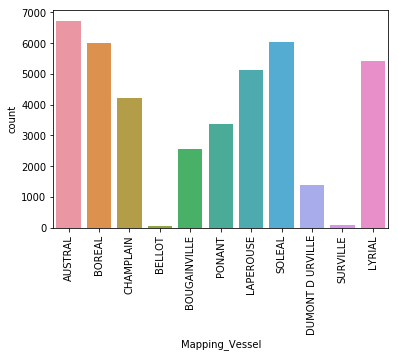

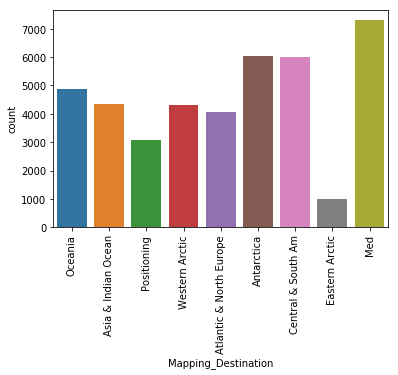

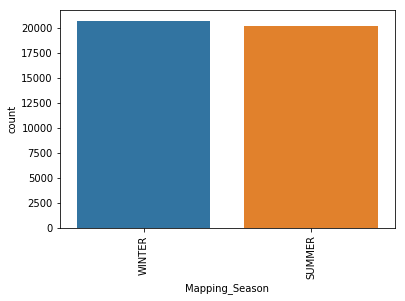

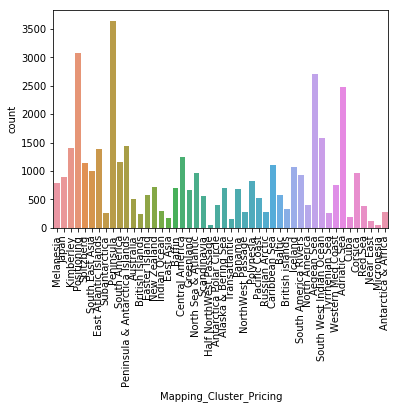

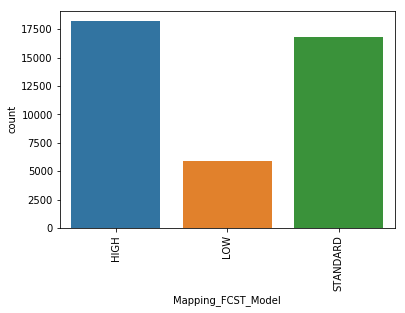

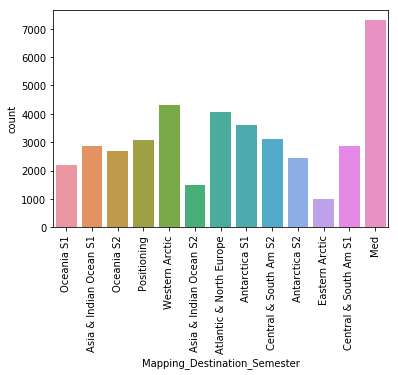

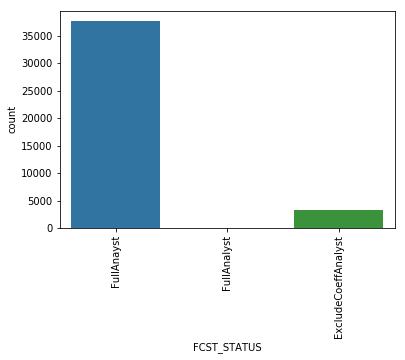

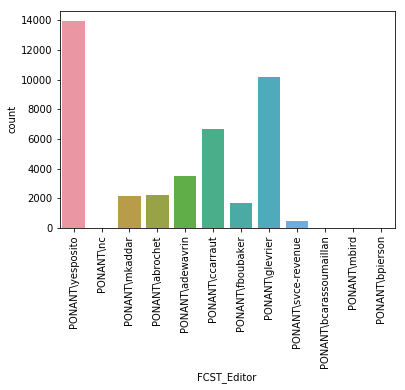

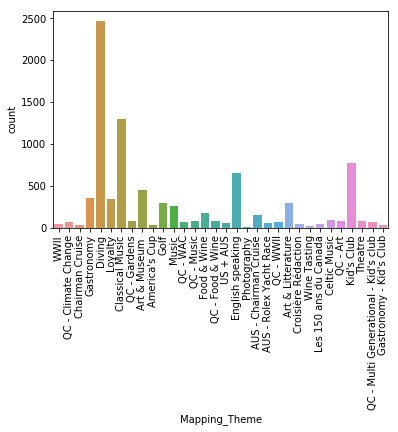

In [33]:
#Répartition de modalités pour les variables catégorielles 
import seaborn as sns
from matplotlib.pyplot import xticks
params = { 'axes.titlesize': 2,}
pylab.rcParams.update(params)
for cat_var in [var for var in categorical_variables if var not in ['Mapping_From_To', 
                                                                    'Mapping_Guest',
                                                                    'Mapping_Partnership',
                                                                    'Mapping_Cluster_Pricing_2',
                                                                    'Key_Cruise_Code',
                                                                    'Mapping_Theme']]:
    sns.countplot(df[cat_var],
                  orient = 'v') 
    xticks(rotation=90)
    plt.show()
sns.countplot(df[df['Mapping_Theme'] != 'No_Theme']['Mapping_Theme'],
              orient = 'v') 
xticks(rotation=90)
plt.show()

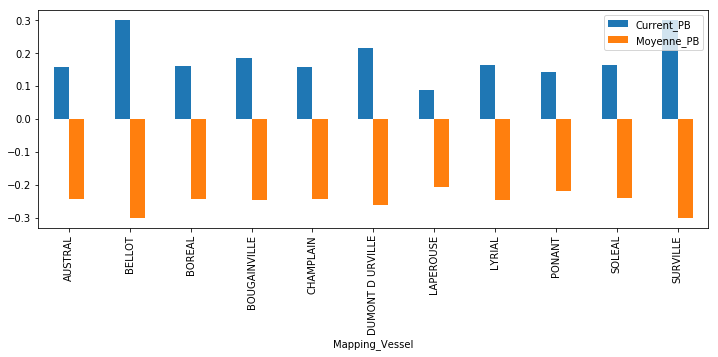

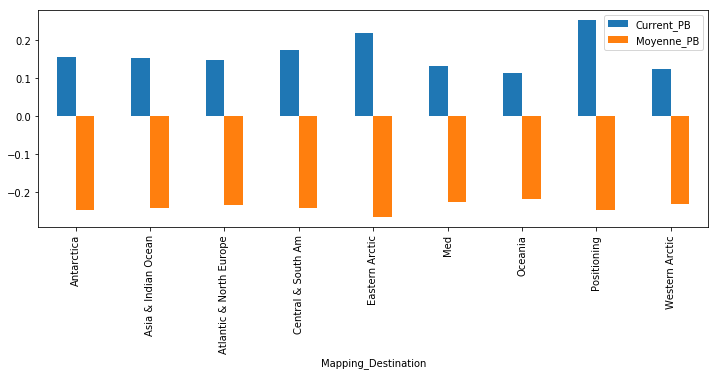

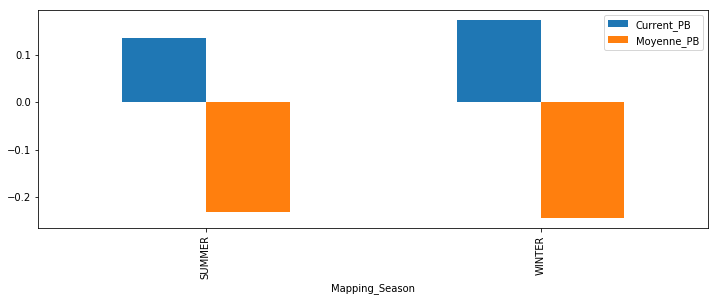

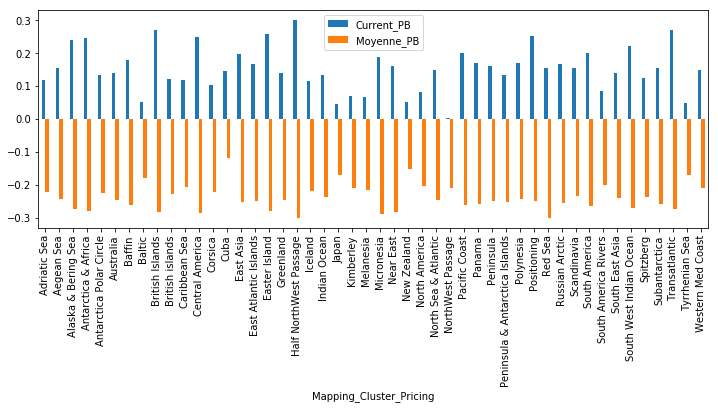

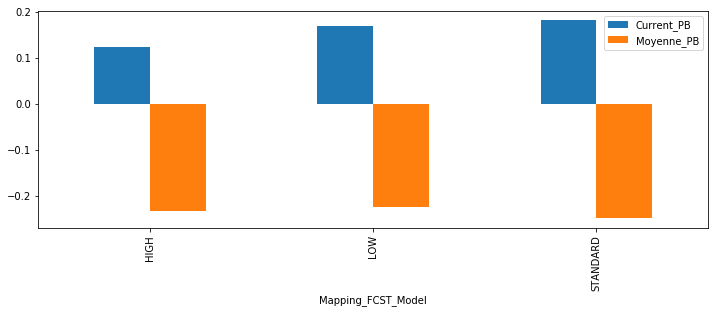

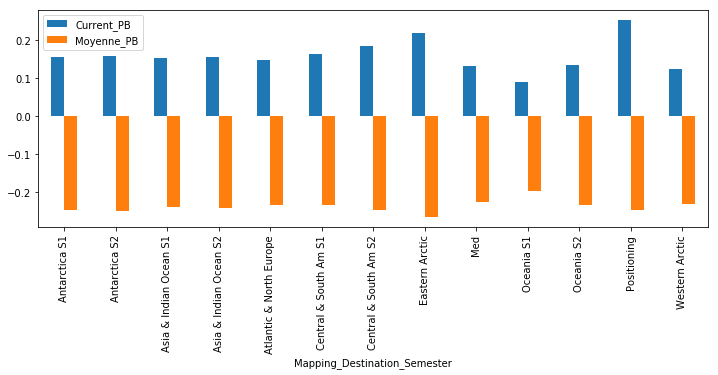

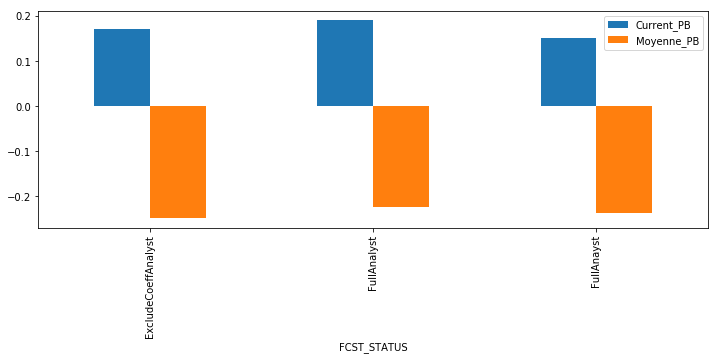

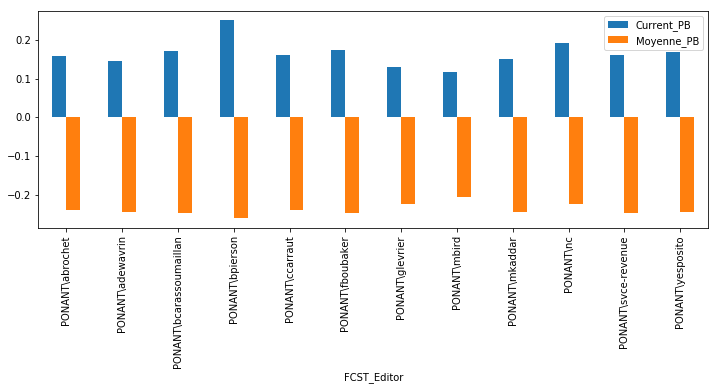

In [34]:
for cat_var in [var for var in categorical_variables if var not in ['Mapping_From_To', 
                                                                    'Mapping_Guest',
                                                                    'Mapping_Partnership',
                                                                    'Mapping_Cluster_Pricing_2',
                                                                    'Key_Cruise_Code',
                                                                    'Mapping_Theme']]:
    df.groupby(cat_var).agg({'Current_PB': 'mean',
                            'Moyenne_PB': 'mean'}).plot(kind = 'bar',
                                                       figsize = (12,4))
    

In [37]:
df['previous_PB_value'].value_counts(dropna = False)


0.00    11902
0.30     9982
0.25     7377
0.20     3026
0.05     2918
0.10     2898
0.15     2845
Name: previous_PB_value, dtype: int64

In [108]:
df[['Key_Cruise_Code',
    'Booking_Date_OBS',
    'previous_PB_value',
    'PB_the_day_before',
    'Current_PB',
    'previous_PB_Changed_Date',
    'PB_CHANGED',
    'PB_Changed_Date',
    'Delay_PB_Changed_Days']].loc[df['Key_Cruise_Code'] == 'A050118']


Key_Cruise_Code Booking_Date_OBS  previous_PB_value  PB_the_day_before  \
586         A050118       2016-11-28               0.30               0.30   
587         A050118       2016-12-05               0.30               0.30   
588         A050118       2016-12-12               0.30               0.30   
589         A050118       2016-12-19               0.30               0.30   
590         A050118       2016-12-26               0.30               0.30   
591         A050118       2017-01-02               0.30               0.30   
592         A050118       2017-01-09               0.30               0.30   
593         A050118       2017-01-16               0.30               0.30   
594         A050118       2017-01-23               0.30               0.30   
595         A050118       2017-01-30               0.30               0.30   
596         A050118       2017-02-06               0.30               0.30   
597         A050118       2017-02-13               0.30               0.30   
598         A050118       2017-02-20               0.30               0.30   
599         A050118       2017-02-27               0.30               0.30   
600         A050118       2017-03-06               0.30               0.30   
601         A050118       2017-03-13               0.30               0.30   
602         A050118       2017-03-20               0.30               0.30   
603         A050118       2017-03-27               0.30               0.30   
604         A050118       2017-04-03               0.30               0.30   
605         A050118       2017-04-10               0.30               0.30   
606         A050118       2017-04-17               0.30               0.30   
607         A050118       2017-04-24               0.30               0.30   
608         A050118       2017-05-01               0.30               0.30   
609         A050118       2017-05-07               0.30               0.30   
610         A050118       2017-05-08               0.30               0.30   
611         A050118       2017-05-15               0.30               0.30   
612         A050118       2017-05-22               0.30               0.30   
613         A050118       2017-05-29               0.30               0.30   
614         A050118       2017-06-05               0.30               0.30   
615         A050118       2017-06-12               0.30               0.30   
616         A050118       2017-06-19               0.30               0.30   
617         A050118       2017-06-26               0.30               0.15   
618         A050118       2017-07-03               0.15               0.15   
619         A050118       2017-07-10               0.15               0.15   
620         A050118       2017-07-17               0.15               0.15   
621         A050118       2017-07-24               0.15               0.15   
622         A050118       2017-07-31               0.15               0.15   
623         A050118       2017-08-07               0.25               0.25   
624         A050118       2017-08-14               0.25               0.25   
625         A050118       2017-08-21               0.25               0.25   
626         A050118       2017-08-28               0.25               0.25   
627         A050118       2017-09-04               0.25               0.25   
628         A050118       2017-09-11               0.25               0.25   
629         A050118       2017-09-18               0.25               0.25   
630         A050118       2017-09-25               0.25               0.25   
631         A050118       2017-10-02               0.25               0.25   
632         A050118       2017-10-09               0.25               0.25   
633         A050118       2017-10-16               0.25               0.25   
634         A050118       2017-10-23               0.25               0.25   
635         A050118       2017-10-30               0.25               0.25   
636         A050118       